# Experiment setup

## Representation Distribution

For this task, we would like to see the compressibility between auto-encoder and PCA.

## Reconstruction

For this task, we would like to show the expressivity between auto-encoder and PCA.

## Dataset

We will use MNIST and LFW

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the autoencoder model with better architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder: reduce dimensionality more gracefully
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)  # Smaller latent space
        )
        # Decoder: mirror the encoder structure
        self.decoder = nn.Sequential(
            nn.Linear(10, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid()  # Output normalized pixel values
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded * 2 - 1  # Rescale output to [-1, 1]


# Load the MNIST dataset with improved preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Center pixel values to [-1, 1]
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)  # Larger batch size for efficiency

# Initialize the model, loss function, and optimizer
model = Autoencoder()
criterion = nn.MSELoss()  # MSE is fine for reconstruction tasks
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Added weight decay for regularization

# Enable GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training loop with added improvements
num_epochs = 20
for epoch in range(num_epochs):
    total_loss = 0
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1).to(device)  # Flatten images and move to device
        output = model(img)
        loss = criterion(output, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

print("Training complete")

Epoch [1/20], Average Loss: 0.2308
Epoch [2/20], Average Loss: 0.1380
Epoch [3/20], Average Loss: 0.1148
Epoch [4/20], Average Loss: 0.1023
Epoch [5/20], Average Loss: 0.0925
Epoch [6/20], Average Loss: 0.0866
Epoch [7/20], Average Loss: 0.0829
Epoch [8/20], Average Loss: 0.0802
Epoch [9/20], Average Loss: 0.0780
Epoch [10/20], Average Loss: 0.0761
Epoch [11/20], Average Loss: 0.0731
Epoch [12/20], Average Loss: 0.0705
Epoch [13/20], Average Loss: 0.0684
Epoch [14/20], Average Loss: 0.0665
Epoch [15/20], Average Loss: 0.0649
Epoch [16/20], Average Loss: 0.0635
Epoch [17/20], Average Loss: 0.0622
Epoch [18/20], Average Loss: 0.0612
Epoch [19/20], Average Loss: 0.0604
Epoch [20/20], Average Loss: 0.0595
Training complete


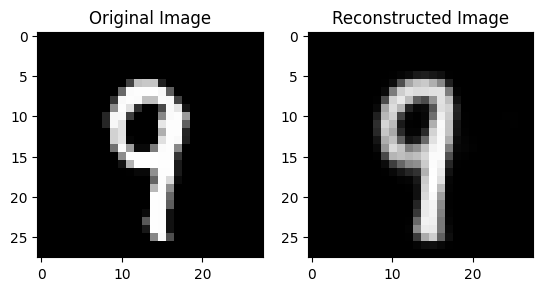

In [27]:
import matplotlib.pyplot as plt

# Get a batch of data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Select an image from the batch
img = images[0].view(1, -1)

# Get the reconstruction from the autoencoder
reconstructed_img = model(img.to(device)).view(-1, 28, 28)

# Convert the images to numpy arrays for plotting
img = img.view(28, 28).detach().numpy()
reconstructed_img = reconstructed_img.cpu().detach().view(28, 28).numpy()

# Plot the original and reconstructed images
fig, axes = plt.subplots(1, 2)
axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(reconstructed_img, cmap='gray')
axes[1].set_title('Reconstructed Image')
plt.show()